# Preparing directory and libraries

In [ ]:
# connecting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# dataset directory
PATH = 'gdrive/MyDrive/Colab Notebooks/project1'
!ls 'gdrive/MyDrive/Colab Notebooks/project1/data'

annotations  images


In [ ]:
# import libraries
import numpy as np
!pip install bs4
from sklearn.model_selection import train_test_split
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from bs4 import BeautifulSoup
import cv2

# Dataset and Dataloader

In [ ]:
class dataset(Dataset) :
    def __init__(self, imgs, labels, transform=None) :
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        
    def __len__(self) :
        return len(self.imgs)
    
    def __getitem__(self, index) :
        x = cv2.imread(self.imgs[index])
        b,g,r = cv2.split(x)           # get b, g, r
        x = cv2.merge([r,g,b])  
        if self.transform is not None:
          x = self.transform(x).to(self.device)
        
        y = dict()
        with open(self.labels[index]) as f :
            data = f.read()
            soup = BeautifulSoup(data, 'xml')
            data = soup.find_all('object')
            size = soup.find_all('size')[0]

            img_width = int(size.find('width').text)
            img_height = int(size.find('height').text)

            masks = np.zeros((len(data), img_width, img_height))
            box = []
            label = []
            box_num = 0
            for obj in data :
                xmin = int(obj.find('xmin').text)
                ymin = int(obj.find('ymin').text)
                xmax = int(obj.find('xmax').text)
                ymax = int(obj.find('ymax').text)
                
                label_ = 1
                if obj.find('name').text == 'with_mask' :
                    label_ = 2
                elif obj.find('name').text == 'mask_weared_incorrect' :
                    label_ = 3
                
                for i in range(xmin, min(xmax + 1, img_width)):
                  for j in range(ymin, min(ymax + 1, img_height)):
                    masks[box_num, i, j] = 1
                box_num += 1

                box.append([xmin, ymin, xmax, ymax])
                label.append(label_)
                
            box = torch.FloatTensor(box)
            label = torch.IntTensor(label)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            image_id = torch.tensor([index])
            area = torch.as_tensor((box[:, 3] - box[:, 1]) * (box[:, 2] - box[:, 0]), dtype=torch.float32)
            # iscrowd is needed in evaluation, which converts everything into coco datatype
            iscrowd = torch.zeros((len(data),), dtype=torch.int64)
            
            y['image_id'] = torch.FloatTensor([index]).to(self.device)
            y['boxes'] = box.to(self.device)
            y['labels'] = torch.as_tensor(label, dtype=torch.int64)
            y['masks'] = masks
            y['area'] = area.to(self.device)
            y['iscrowd'] = iscrowd.to(self.device)

        return x, y

In [ ]:
# dataset directory
imgs_dir = list(sorted(glob(PATH + '/data/images/*.png')))
labels_dir = list(sorted(glob(PATH + "/data/annotations/*.xml")))

# split train, valid, and test set
trainX, testX, trainY, testY = train_test_split(imgs_dir, labels_dir,	test_size=0.2, random_state=4211)
validX, testX, validY, testY = train_test_split(testX, testY,	test_size=0.5, random_state=4211)

In [ ]:
def collate_fn(batch) : return tuple(zip(*batch))
train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.GaussianBlur(5, sigma=(0.1, 0.3)),
            transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))
            # transforms.RandomHorizontalFlip(0.5)
            ])
train_data = dataset(trainX, trainY, train_transform)
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True,
                       collate_fn = collate_fn)

valid_transform = transforms.ToTensor()
valid_data = dataset(validX, validY, valid_transform)
valid_loader = DataLoader(valid_data, batch_size = 4, shuffle = False,
                       collate_fn = collate_fn)

test_transform = transforms.ToTensor()
test_data = dataset(testX, testY, test_transform)
test_loader = DataLoader(test_data, batch_size = 4, shuffle = False,
                       collate_fn = collate_fn)

# Preparing libraries and helpers for training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
# import libraries
!pip install tqdm
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.functional as F
import torchvision.models as models
import torchvision.ops as ops

# install coco utils
!pip install cython
!pip install pycocotools

import sys
import os
py_file_location = "/content/gdrive/MyDrive/Colab Notebooks/project1/pyhelper"
sys.path.append(os.path.abspath(py_file_location))

from engine import train_one_epoch, evaluate
import utils

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# training and testing helper functions
def save_checkpoint(save_path, model, optimizer, run_ap):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'run_ap': run_ap}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    run_ap = state_dict['run_ap']
    print(f'Model loaded from {save_path}, with average precision: {run_ap}')
    return run_ap

def inner_summarize(evaluation, ap=1, iouThr=None, maxDets=100 ):
    p = evaluation.params

    aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == 'all']
    mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
    if ap == 1:
        # dimension of precision: [TxRxKxAxM]
        s = evaluation.eval['precision']
        # IoU
        if iouThr is not None:
            t = np.where(iouThr == p.iouThrs)[0]
            s = s[t]
        s = s[:,:,:,aind,mind]
    else:
        # dimension of recall: [TxKxAxM]
        s = evaluation.eval['recall']
        if iouThr is not None:
            t = np.where(iouThr == p.iouThrs)[0]
            s = s[t]
        s = s[:,:,aind,mind]
    if len(s[s>-1])==0:
        mean_s = -1
    else:
        mean_s = np.mean(s[s>-1])
    return mean_s

def TRAIN(model, train_loader, valid_loader, step_lr_scheduler, num_epochs, optimizer, run_ap, device, save_name, loss_name, ap_name, ap_inter_name):
    if run_ap==None:
          best_run_ap = float("-Inf")  
    else: 
          best_run_ap = run_ap
          print('Resume training')
    
    train_loss_list = []
    AP_list = []
    AP_interpolate_list = []
    lr_scheduler = None
    for epoch in range(num_epochs) :
        model.train()
        running_loss = 0

        if epoch == 0:
            warmup_factor = 1. / 1000
            warmup_iters = min(1000, len(train_loader) - 1)
            lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

        for imgs, annotations in tqdm(train_loader):
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            
            # Forward pass
            predict = model(imgs, annotations)
            losses = sum(loss for loss in predict.values())        

            # Backward and optimize
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            if lr_scheduler is not None:
                lr_scheduler.step()

            running_loss += losses
        
        # StepLR after each epoch
        if step_lr_scheduler is not None:
          step_lr_scheduler.step()
        # evaluate model 
        evaluation = evaluate(model, valid_loader, device=device)

        for iou_type, coco_eval in evaluation.coco_eval.items():
            if iou_type == 'bbox' :
              mean_ap = inner_summarize(coco_eval, ap=1)
              mean_ap_inter = inner_summarize(coco_eval, ap=1, iouThr=.5, maxDets=coco_eval.params.maxDets[2])
              mean_rc = inner_summarize(coco_eval, ap=0, maxDets=coco_eval.params.maxDets[0])
        if mean_ap > best_run_ap:
            best_run_ap = mean_ap
            save_checkpoint(save_name, model, optimizer, best_run_ap)
        
        train_loss_list.append(running_loss)
        AP_list.append(mean_ap)
        AP_interpolate_list.append(mean_ap_inter)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Average Precision: {:.4f}, Average Recall: {:.4f}' 
                    .format(epoch+1, num_epochs, running_loss, mean_ap, mean_rc))
        
    print('Highest Precision: {:.4f}'.format(best_run_ap))        
    print('Finished Training \n')

    with open(loss_name, 'w') as filehandle:
        filehandle.writelines("%s\n" % loss for loss in train_loss_list)
    with open(ap_name, 'w') as filehandle:
        filehandle.writelines("%s\n" % ap for ap in AP_list)
    with open(ap_inter_name, 'w') as filehandle:
        filehandle.writelines("%s\n" % ap for ap in AP_interpolate_list)

def non_max_suppression_fast(boxes, labels, overlapThresh):
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    x1, y1, x2, y2 = x1.cpu(), y1.cpu(), x2.cpu(), y2.cpu()
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
      # grab the last index in the indexes list and add the
      # index value to the list of picked indexes
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i.item())
      # find the largest (x, y) coordinates for the start of
      # the bounding box and the smallest (x, y) coordinates
      # for the end of the bounding box
      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])
      # compute the width and height of the bounding box
      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)
      # compute the ratio of overlap
      overlap = (w * h) / area[idxs[:last]]
      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked
    return boxes[pick], labels[pick]

def plot_img(img, predict, annotation) :
    fig, ax = plt.subplots(1, 2)
    img = img.cpu().data
    
    ax[0].imshow(img.permute(1, 2, 0)) #rgb, w, h => w, h, rgb
    ax[1].imshow(img.permute(1, 2, 0))
    ax[0].set_title("real")
    ax[1].set_title("predict")
    
    for box, label in zip(annotation["boxes"], annotation["labels"]) :
        xmin, ymin, xmax, ymax = box
        if label == 2:
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='limegreen',facecolor='none')
        elif label == 1 or label == 3:
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)

    # if there are no boxes, skip nms
    if (len(predict["labels"]) != 0 and len(predict["boxes"])) != 0 :
        predict["boxes"], predict["labels"]= non_max_suppression_fast(predict["boxes"], predict["labels"], 0.3)
    for box, label in zip(predict["boxes"], predict["labels"]) :
        xmin, ymin, xmax, ymax = box
        if label == 2:
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='limegreen',facecolor='none')
        elif label == 1 or label == 3:
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
    plt.show()

def TEST(model, valid_loader, device):
    with torch.no_grad():
        model.eval()

        img_plot = []
        img_predict = []
        img_annot = []
        for imgs, annotations in tqdm(valid_loader):
            
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in annotations]

            predict = model(imgs)
            
            for i in range(len(imgs)):
              img_plot.append(imgs[i])
              img_predict.append(predict[i])
              img_annot.append(annotations[i])

        for i in range(len(img_plot)):
            plot_img(img_plot[i], img_predict[i], img_annot[i])

# Improving Model Training

## Using Faster R-CNN with ResNet50 Feature Pyramid Networks (FPN)

In [ ]:
# load pretrained model
def get_model_frcnn(num_classes) :
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes+1)
    return model

In [ ]:
# Faster R-CNN Architecture
model_frcnn = get_model_frcnn(3).to(device)
model_frcnn

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
params = [p for p in model_frcnn.parameters() if p.requires_grad]
num_epochs = 30
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = None
best_run_ap = None
save_name_frcnn = PATH + f'/checkpoints/faster_rcnn.pt'
loss_frcnn = PATH + f'/loss_list/loss_faster_rcnn.txt'
ap_frcnn = PATH + f'/loss_list/ap_faster_rcnn.txt'
inter_frcnn = PATH + f'/loss_list/inter_faster_rcnn.txt'

TRAIN(model_frcnn, train_loader, valid_loader, lr_scheduler, num_epochs, optimizer, best_run_ap, device, save_name_frcnn, loss_frcnn, ap_frcnn, inter_frcnn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.2033 (0.2033)  evaluator_time: 0.0139 (0.0139)  time: 0.2906  data: 0.0731  max mem: 7917
Test:  [21/22]  eta: 0:00:00  model_time: 0.1874 (0.1804)  evaluator_time: 0.0113 (0.0147)  time: 0.2758  data: 0.0845  max mem: 7917
Test: Total time: 0:00:06 (0.2811 s / it)
Averaged stats: model_time: 0.1874 (0.1804)  evaluator_time: 0.0113 (0.0147)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.733
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1924 (0.1924)  evaluator_time: 0.0095 (0.0095)  time: 0.2749  data: 0.0727  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1874 (0.1802)  evaluator_time: 0.0084 (0.0106)  time: 0.2705  data: 0.0826  max mem: 8289
Test: Total time: 0:00:06 (0.2748 s / it)
Averaged stats: model_time: 0.1874 (0.1802)  evaluator_time: 0.0084 (0.0106)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1938 (0.1938)  evaluator_time: 0.0071 (0.0071)  time: 0.2674  data: 0.0663  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1883 (0.1807)  evaluator_time: 0.0074 (0.0092)  time: 0.2686  data: 0.0814  max mem: 8289
Test: Total time: 0:00:05 (0.2726 s / it)
Averaged stats: model_time: 0.1883 (0.1807)  evaluator_time: 0.0074 (0.0092)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.822
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1918 (0.1918)  evaluator_time: 0.0068 (0.0068)  time: 0.2719  data: 0.0730  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1881 (0.1802)  evaluator_time: 0.0064 (0.0082)  time: 0.2700  data: 0.0841  max mem: 8289
Test: Total time: 0:00:06 (0.2739 s / it)
Averaged stats: model_time: 0.1881 (0.1802)  evaluator_time: 0.0064 (0.0082)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1926 (0.1926)  evaluator_time: 0.0069 (0.0069)  time: 0.2763  data: 0.0766  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1879 (0.1815)  evaluator_time: 0.0074 (0.0088)  time: 0.2818  data: 0.0934  max mem: 8289
Test: Total time: 0:00:06 (0.2849 s / it)
Averaged stats: model_time: 0.1879 (0.1815)  evaluator_time: 0.0074 (0.0088)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1937 (0.1937)  evaluator_time: 0.0074 (0.0074)  time: 0.2796  data: 0.0783  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1877 (0.1814)  evaluator_time: 0.0062 (0.0079)  time: 0.2722  data: 0.0853  max mem: 8289
Test: Total time: 0:00:06 (0.2766 s / it)
Averaged stats: model_time: 0.1877 (0.1814)  evaluator_time: 0.0062 (0.0079)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1923 (0.1923)  evaluator_time: 0.0071 (0.0071)  time: 0.2765  data: 0.0770  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1884 (0.1807)  evaluator_time: 0.0069 (0.0081)  time: 0.2730  data: 0.0863  max mem: 8289
Test: Total time: 0:00:06 (0.2768 s / it)
Averaged stats: model_time: 0.1884 (0.1807)  evaluator_time: 0.0069 (0.0081)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1944 (0.1944)  evaluator_time: 0.0071 (0.0071)  time: 0.2704  data: 0.0687  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1873 (0.1812)  evaluator_time: 0.0054 (0.0078)  time: 0.2727  data: 0.0864  max mem: 8289
Test: Total time: 0:00:06 (0.2770 s / it)
Averaged stats: model_time: 0.1873 (0.1812)  evaluator_time: 0.0054 (0.0078)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1928 (0.1928)  evaluator_time: 0.0075 (0.0075)  time: 0.2715  data: 0.0710  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1898 (0.1807)  evaluator_time: 0.0067 (0.0082)  time: 0.2705  data: 0.0841  max mem: 8289
Test: Total time: 0:00:06 (0.2745 s / it)
Averaged stats: model_time: 0.1898 (0.1807)  evaluator_time: 0.0067 (0.0082)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1934 (0.1934)  evaluator_time: 0.0072 (0.0072)  time: 0.2743  data: 0.0735  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1874 (0.1807)  evaluator_time: 0.0058 (0.0078)  time: 0.2752  data: 0.0891  max mem: 8289
Test: Total time: 0:00:06 (0.2785 s / it)
Averaged stats: model_time: 0.1874 (0.1807)  evaluator_time: 0.0058 (0.0078)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.849
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1943 (0.1943)  evaluator_time: 0.0068 (0.0068)  time: 0.2759  data: 0.0746  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1878 (0.1806)  evaluator_time: 0.0059 (0.0078)  time: 0.2684  data: 0.0826  max mem: 8289
Test: Total time: 0:00:05 (0.2724 s / it)
Averaged stats: model_time: 0.1878 (0.1806)  evaluator_time: 0.0059 (0.0078)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.841
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1926 (0.1926)  evaluator_time: 0.0071 (0.0071)  time: 0.2715  data: 0.0716  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1879 (0.1808)  evaluator_time: 0.0056 (0.0076)  time: 0.2699  data: 0.0837  max mem: 8289
Test: Total time: 0:00:06 (0.2739 s / it)
Averaged stats: model_time: 0.1879 (0.1808)  evaluator_time: 0.0056 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1930 (0.1930)  evaluator_time: 0.0074 (0.0074)  time: 0.2719  data: 0.0713  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1880 (0.1858)  evaluator_time: 0.0066 (0.0079)  time: 0.2782  data: 0.0864  max mem: 8289
Test: Total time: 0:00:06 (0.2814 s / it)
Averaged stats: model_time: 0.1880 (0.1858)  evaluator_time: 0.0066 (0.0079)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.820
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1927 (0.1927)  evaluator_time: 0.0068 (0.0068)  time: 0.2688  data: 0.0692  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1884 (0.1808)  evaluator_time: 0.0057 (0.0077)  time: 0.2689  data: 0.0830  max mem: 8289
Test: Total time: 0:00:06 (0.2728 s / it)
Averaged stats: model_time: 0.1884 (0.1808)  evaluator_time: 0.0057 (0.0077)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.831
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1967 (0.1967)  evaluator_time: 0.0076 (0.0076)  time: 0.2817  data: 0.0772  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1902 (0.1818)  evaluator_time: 0.0065 (0.0078)  time: 0.2726  data: 0.0857  max mem: 8289
Test: Total time: 0:00:06 (0.2770 s / it)
Averaged stats: model_time: 0.1902 (0.1818)  evaluator_time: 0.0065 (0.0078)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.857
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1953 (0.1953)  evaluator_time: 0.0071 (0.0071)  time: 0.2762  data: 0.0736  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1879 (0.1806)  evaluator_time: 0.0059 (0.0076)  time: 0.2690  data: 0.0834  max mem: 8289
Test: Total time: 0:00:06 (0.2732 s / it)
Averaged stats: model_time: 0.1879 (0.1806)  evaluator_time: 0.0059 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1956 (0.1956)  evaluator_time: 0.0074 (0.0074)  time: 0.2760  data: 0.0729  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1898 (0.1816)  evaluator_time: 0.0056 (0.0076)  time: 0.2722  data: 0.0856  max mem: 8289
Test: Total time: 0:00:06 (0.2762 s / it)
Averaged stats: model_time: 0.1898 (0.1816)  evaluator_time: 0.0056 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.845
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1927 (0.1927)  evaluator_time: 0.0074 (0.0074)  time: 0.2744  data: 0.0741  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1880 (0.1816)  evaluator_time: 0.0056 (0.0079)  time: 0.2775  data: 0.0903  max mem: 8289
Test: Total time: 0:00:06 (0.2808 s / it)
Averaged stats: model_time: 0.1880 (0.1816)  evaluator_time: 0.0056 (0.0079)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.836
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1926 (0.1926)  evaluator_time: 0.0075 (0.0075)  time: 0.2745  data: 0.0743  max mem: 8289
Test:  [21/22]  eta: 0:00:00  model_time: 0.1891 (0.1812)  evaluator_time: 0.0061 (0.0076)  time: 0.2715  data: 0.0851  max mem: 8289
Test: Total time: 0:00:06 (0.2755 s / it)
Averaged stats: model_time: 0.1891 (0.1812)  evaluator_time: 0.0061 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.846
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1951 (0.1951)  evaluator_time: 0.0072 (0.0072)  time: 0.2781  data: 0.0755  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1893 (0.1818)  evaluator_time: 0.0056 (0.0076)  time: 0.2750  data: 0.0880  max mem: 8293
Test: Total time: 0:00:06 (0.2788 s / it)
Averaged stats: model_time: 0.1893 (0.1818)  evaluator_time: 0.0056 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.829
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.829
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1950 (0.1950)  evaluator_time: 0.0072 (0.0072)  time: 0.2825  data: 0.0802  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1885 (0.1824)  evaluator_time: 0.0060 (0.0079)  time: 0.2791  data: 0.0910  max mem: 8293
Test: Total time: 0:00:06 (0.2830 s / it)
Averaged stats: model_time: 0.1885 (0.1824)  evaluator_time: 0.0060 (0.0079)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1936 (0.1936)  evaluator_time: 0.0069 (0.0069)  time: 0.2730  data: 0.0723  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1899 (0.1817)  evaluator_time: 0.0060 (0.0075)  time: 0.2739  data: 0.0870  max mem: 8293
Test: Total time: 0:00:06 (0.2777 s / it)
Averaged stats: model_time: 0.1899 (0.1817)  evaluator_time: 0.0060 (0.0075)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1973 (0.1973)  evaluator_time: 0.0073 (0.0073)  time: 0.2853  data: 0.0804  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1884 (0.1814)  evaluator_time: 0.0059 (0.0077)  time: 0.2737  data: 0.0870  max mem: 8293
Test: Total time: 0:00:06 (0.2781 s / it)
Averaged stats: model_time: 0.1884 (0.1814)  evaluator_time: 0.0059 (0.0077)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.788
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.845
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1930 (0.1930)  evaluator_time: 0.0076 (0.0076)  time: 0.2796  data: 0.0788  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1902 (0.1811)  evaluator_time: 0.0066 (0.0079)  time: 0.2712  data: 0.0849  max mem: 8293
Test: Total time: 0:00:06 (0.2757 s / it)
Averaged stats: model_time: 0.1902 (0.1811)  evaluator_time: 0.0066 (0.0079)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.851
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1938 (0.1938)  evaluator_time: 0.0069 (0.0069)  time: 0.2761  data: 0.0751  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1886 (0.1826)  evaluator_time: 0.0056 (0.0076)  time: 0.2752  data: 0.0875  max mem: 8293
Test: Total time: 0:00:06 (0.2792 s / it)
Averaged stats: model_time: 0.1886 (0.1826)  evaluator_time: 0.0056 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.828
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.851
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1929 (0.1929)  evaluator_time: 0.0065 (0.0065)  time: 0.2743  data: 0.0748  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1897 (0.1815)  evaluator_time: 0.0061 (0.0075)  time: 0.2717  data: 0.0852  max mem: 8293
Test: Total time: 0:00:06 (0.2757 s / it)
Averaged stats: model_time: 0.1897 (0.1815)  evaluator_time: 0.0061 (0.0075)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1924 (0.1924)  evaluator_time: 0.0068 (0.0068)  time: 0.2760  data: 0.0766  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1912 (0.1828)  evaluator_time: 0.0057 (0.0076)  time: 0.2783  data: 0.0902  max mem: 8293
Test: Total time: 0:00:06 (0.2818 s / it)
Averaged stats: model_time: 0.1912 (0.1828)  evaluator_time: 0.0057 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.827
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.872
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1950 (0.1950)  evaluator_time: 0.0079 (0.0079)  time: 0.2745  data: 0.0714  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1897 (0.1813)  evaluator_time: 0.0061 (0.0078)  time: 0.2721  data: 0.0857  max mem: 8293
Test: Total time: 0:00:06 (0.2812 s / it)
Averaged stats: model_time: 0.1897 (0.1813)  evaluator_time: 0.0061 (0.0078)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.836
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1931 (0.1931)  evaluator_time: 0.0068 (0.0068)  time: 0.2745  data: 0.0744  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1877 (0.1811)  evaluator_time: 0.0055 (0.0073)  time: 0.2701  data: 0.0843  max mem: 8293
Test: Total time: 0:00:06 (0.2744 s / it)
Averaged stats: model_time: 0.1877 (0.1811)  evaluator_time: 0.0055 (0.0073)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.846
 Average Recall     (AR) @[ IoU


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1913 (0.1913)  evaluator_time: 0.0072 (0.0072)  time: 0.2801  data: 0.0815  max mem: 8293
Test:  [21/22]  eta: 0:00:00  model_time: 0.1879 (0.1817)  evaluator_time: 0.0055 (0.0075)  time: 0.2770  data: 0.0898  max mem: 8293
Test: Total time: 0:00:06 (0.2806 s / it)
Averaged stats: model_time: 0.1879 (0.1817)  evaluator_time: 0.0055 (0.0075)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.871
 Average Recall     (AR) @[ IoU

In [ ]:
TEST(model_frcnn, test_loader, device)

Output hidden; open in https://colab.research.google.com to view.

## Using Mask R-CNN

### Modifying the model by using MobileNetV2 backbone

In [ ]:
def get_model_mask_backbone(num_classes):

    # load a pre-trained model for classification and return only the features
    mobilenet_backbone = models.mobilenet_v2(pretrained=True).features
    # FasterRCNN needs to know the number of output channels in a backbone. For mobilenet_v2, it is 1280 but with the dataset its is 256
    mobilenet_backbone.out_channels = 1280

    # make the RPN generate 5 x 3 anchors per spatial location, with 5 different sizes and 3 different aspect
    # ratios. Here, we have a Tuple[Tuple[int]] because each feature map could potentially have different sizes and
    # aspect ratios
    anchor_generator = models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                         aspect_ratios=((0.5, 1.0, 2.0),))
                                                        
    mobilenet_backbone_head = models.detection.rpn.RPNHead(1280, anchor_generator.num_anchors_per_location()[0])

    # define feature maps that will be used to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.if backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an OrderedDict[Tensor], and 
    # in featmap_names we can choose which feature maps to use.
    roi_pooler = ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

    # put the pieces together inside a MaskRCNN model
    model_mask_backbone = models.detection.MaskRCNN(mobilenet_backbone, num_classes+1, rpn_anchor_generator=anchor_generator, rpn_head=mobilenet_backbone_head, box_roi_pool=roi_pooler)

    return model_mask_backbone


In [ ]:
# model_mask_backbone architecture
model_mask_backbone = get_model_mask_backbone(3).to(device)
model_mask_backbone

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
params = [p for p in model_mask_backbone.parameters() if p.requires_grad]
num_epochs = 30
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
best_run_ap = None
save_name_mask_backbone = PATH + f'/checkpoints/mask_backbone.pt'
loss_mask_backbone = PATH + f'/loss_list/loss_mask_backbone.txt'
ap_mask_backbone = PATH + f'/loss_list/ap_mask_backbone.txt'
inter_mask_backbone = PATH + f'/loss_list/inter_mask_backbone.txt'

TRAIN(model_mask_backbone, train_loader, valid_loader, lr_scheduler, num_epochs, optimizer, best_run_ap, device, save_name_mask_backbone, loss_mask_backbone, ap_mask_backbone, inter_mask_backbone)


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:13  model_time: 0.3440 (0.3440)  evaluator_time: 0.1871 (0.1871)  time: 0.5994  data: 0.0681  max mem: 9788
Test:  [21/22]  eta: 0:00:00  model_time: 0.2524 (0.2666)  evaluator_time: 0.1140 (0.1435)  time: 0.4765  data: 0.0787  max mem: 9788
Test: Total time: 0:00:10 (0.4916 s / it)
Averaged stats: model_time: 0.2524 (0.2666)  evaluator_time: 0.1140 (0.1435)
Accumulating evaluation results...
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:07  model_time: 0.1865 (0.1865)  evaluator_time: 0.1054 (0.1054)  time: 0.3617  data: 0.0696  max mem: 9788
Test:  [21/22]  eta: 0:00:00  model_time: 0.2112 (0.2048)  evaluator_time: 0.0998 (0.1106)  time: 0.3906  data: 0.0800  max mem: 9788
Test: Total time: 0:00:08 (0.3977 s / it)
Averaged stats: model_time: 0.2112 (0.2048)  evaluator_time: 0.0998 (0.1106)
Accumulating evaluation results...
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1489 (0.1489)  evaluator_time: 0.0649 (0.0649)  time: 0.2847  data: 0.0707  max mem: 10100
Test:  [21/22]  eta: 0:00:00  model_time: 0.1504 (0.1581)  evaluator_time: 0.0472 (0.0675)  time: 0.3008  data: 0.0800  max mem: 10100
Test: Total time: 0:00:06 (0.3077 s / it)
Averaged stats: model_time: 0.1504 (0.1581)  evaluator_time: 0.0472 (0.0675)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1339 (0.1339)  evaluator_time: 0.0627 (0.0627)  time: 0.2641  data: 0.0673  max mem: 10100
Test:  [21/22]  eta: 0:00:00  model_time: 0.1288 (0.1347)  evaluator_time: 0.0398 (0.0536)  time: 0.2650  data: 0.0843  max mem: 10100
Test: Total time: 0:00:06 (0.2743 s / it)
Averaged stats: model_time: 0.1288 (0.1347)  evaluator_time: 0.0398 (0.0536)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1280 (0.1280)  evaluator_time: 0.0458 (0.0458)  time: 0.2477  data: 0.0738  max mem: 10100
Test:  [21/22]  eta: 0:00:00  model_time: 0.1343 (0.1392)  evaluator_time: 0.0372 (0.0518)  time: 0.2659  data: 0.0813  max mem: 10100
Test: Total time: 0:00:06 (0.2745 s / it)
Averaged stats: model_time: 0.1343 (0.1392)  evaluator_time: 0.0372 (0.0518)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:07  model_time: 0.1753 (0.1753)  evaluator_time: 0.0964 (0.0964)  time: 0.3441  data: 0.0722  max mem: 10100
Test:  [21/22]  eta: 0:00:00  model_time: 0.1657 (0.1691)  evaluator_time: 0.0649 (0.0762)  time: 0.3190  data: 0.0792  max mem: 10100
Test: Total time: 0:00:07 (0.3273 s / it)
Averaged stats: model_time: 0.1657 (0.1691)  evaluator_time: 0.0649 (0.0762)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1330 (0.1330)  evaluator_time: 0.0623 (0.0623)  time: 0.2631  data: 0.0676  max mem: 10100
Test:  [21/22]  eta: 0:00:00  model_time: 0.1313 (0.1353)  evaluator_time: 0.0436 (0.0517)  time: 0.2649  data: 0.0831  max mem: 10100
Test: Total time: 0:00:05 (0.2718 s / it)
Averaged stats: model_time: 0.1313 (0.1353)  evaluator_time: 0.0436 (0.0517)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1308 (0.1308)  evaluator_time: 0.0433 (0.0433)  time: 0.2404  data: 0.0660  max mem: 10100
Test:  [21/22]  eta: 0:00:00  model_time: 0.1256 (0.1249)  evaluator_time: 0.0352 (0.0411)  time: 0.2394  data: 0.0792  max mem: 10100
Test: Total time: 0:00:05 (0.2473 s / it)
Averaged stats: model_time: 0.1256 (0.1249)  evaluator_time: 0.0352 (0.0411)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1273 (0.1273)  evaluator_time: 0.0498 (0.0498)  time: 0.2440  data: 0.0667  max mem: 10283
Test:  [21/22]  eta: 0:00:00  model_time: 0.1295 (0.1322)  evaluator_time: 0.0416 (0.0488)  time: 0.2610  data: 0.0845  max mem: 10283
Test: Total time: 0:00:05 (0.2680 s / it)
Averaged stats: model_time: 0.1295 (0.1322)  evaluator_time: 0.0416 (0.0488)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1093 (0.1093)  evaluator_time: 0.0754 (0.0754)  time: 0.2655  data: 0.0807  max mem: 10283
Test:  [21/22]  eta: 0:00:00  model_time: 0.1092 (0.1096)  evaluator_time: 0.0267 (0.0354)  time: 0.2214  data: 0.0820  max mem: 10283
Test: Total time: 0:00:05 (0.2302 s / it)
Averaged stats: model_time: 0.1092 (0.1096)  evaluator_time: 0.0267 (0.0354)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1184 (0.1184)  evaluator_time: 0.0378 (0.0378)  time: 0.2285  data: 0.0721  max mem: 10582
Test:  [21/22]  eta: 0:00:00  model_time: 0.1260 (0.1220)  evaluator_time: 0.0308 (0.0354)  time: 0.2371  data: 0.0842  max mem: 10582
Test: Total time: 0:00:05 (0.2431 s / it)
Averaged stats: model_time: 0.1260 (0.1220)  evaluator_time: 0.0308 (0.0354)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1069 (0.1069)  evaluator_time: 0.0311 (0.0311)  time: 0.2068  data: 0.0686  max mem: 10582
Test:  [21/22]  eta: 0:00:00  model_time: 0.1042 (0.1027)  evaluator_time: 0.0184 (0.0243)  time: 0.2039  data: 0.0814  max mem: 10582
Test: Total time: 0:00:04 (0.2099 s / it)
Averaged stats: model_time: 0.1042 (0.1027)  evaluator_time: 0.0184 (0.0243)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1369 (0.1369)  evaluator_time: 0.0662 (0.0662)  time: 0.2695  data: 0.0662  max mem: 10582
Test:  [21/22]  eta: 0:00:00  model_time: 0.1325 (0.1416)  evaluator_time: 0.0407 (0.0575)  time: 0.2736  data: 0.0796  max mem: 10582
Test: Total time: 0:00:06 (0.2804 s / it)
Averaged stats: model_time: 0.1325 (0.1416)  evaluator_time: 0.0407 (0.0575)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.0979 (0.0979)  evaluator_time: 0.0242 (0.0242)  time: 0.1939  data: 0.0717  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1065 (0.1085)  evaluator_time: 0.0247 (0.0328)  time: 0.2193  data: 0.0826  max mem: 10760
Test: Total time: 0:00:05 (0.2303 s / it)
Averaged stats: model_time: 0.1065 (0.1085)  evaluator_time: 0.0247 (0.0328)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1235 (0.1235)  evaluator_time: 0.0368 (0.0368)  time: 0.2350  data: 0.0745  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1255 (0.1277)  evaluator_time: 0.0331 (0.0410)  time: 0.2424  data: 0.0786  max mem: 10760
Test: Total time: 0:00:05 (0.2495 s / it)
Averaged stats: model_time: 0.1255 (0.1277)  evaluator_time: 0.0331 (0.0410)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1086 (0.1086)  evaluator_time: 0.0272 (0.0272)  time: 0.2047  data: 0.0688  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1068 (0.1066)  evaluator_time: 0.0201 (0.0264)  time: 0.2084  data: 0.0798  max mem: 10760
Test: Total time: 0:00:04 (0.2145 s / it)
Averaged stats: model_time: 0.1068 (0.1066)  evaluator_time: 0.0201 (0.0264)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1124 (0.1124)  evaluator_time: 0.0398 (0.0398)  time: 0.2243  data: 0.0719  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1099 (0.1132)  evaluator_time: 0.0257 (0.0339)  time: 0.2233  data: 0.0782  max mem: 10760
Test: Total time: 0:00:05 (0.2284 s / it)
Averaged stats: model_time: 0.1099 (0.1132)  evaluator_time: 0.0257 (0.0339)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1300 (0.1300)  evaluator_time: 0.0498 (0.0498)  time: 0.2467  data: 0.0663  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1208 (0.1183)  evaluator_time: 0.0289 (0.0371)  time: 0.2346  data: 0.0813  max mem: 10760
Test: Total time: 0:00:05 (0.2401 s / it)
Averaged stats: model_time: 0.1208 (0.1183)  evaluator_time: 0.0289 (0.0371)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1081 (0.1081)  evaluator_time: 0.0824 (0.0824)  time: 0.2743  data: 0.0836  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1211 (0.1186)  evaluator_time: 0.0305 (0.0408)  time: 0.2398  data: 0.0843  max mem: 10760
Test: Total time: 0:00:05 (0.2477 s / it)
Averaged stats: model_time: 0.1211 (0.1186)  evaluator_time: 0.0305 (0.0408)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1304 (0.1304)  evaluator_time: 0.0492 (0.0492)  time: 0.2714  data: 0.0916  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1223 (0.1235)  evaluator_time: 0.0389 (0.0427)  time: 0.2529  data: 0.0883  max mem: 10760
Test: Total time: 0:00:05 (0.2587 s / it)
Averaged stats: model_time: 0.1223 (0.1235)  evaluator_time: 0.0389 (0.0427)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1095 (0.1095)  evaluator_time: 0.0270 (0.0270)  time: 0.2360  data: 0.0993  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1079 (0.1081)  evaluator_time: 0.0212 (0.0274)  time: 0.2177  data: 0.0837  max mem: 10760
Test: Total time: 0:00:04 (0.2237 s / it)
Averaged stats: model_time: 0.1079 (0.1081)  evaluator_time: 0.0212 (0.0274)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1106 (0.1106)  evaluator_time: 0.0818 (0.0818)  time: 0.2802  data: 0.0876  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1116 (0.1108)  evaluator_time: 0.0264 (0.0332)  time: 0.2264  data: 0.0866  max mem: 10760
Test: Total time: 0:00:05 (0.2343 s / it)
Averaged stats: model_time: 0.1116 (0.1108)  evaluator_time: 0.0264 (0.0332)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1045 (0.1045)  evaluator_time: 0.0680 (0.0680)  time: 0.2452  data: 0.0726  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1048 (0.1050)  evaluator_time: 0.0204 (0.0277)  time: 0.2134  data: 0.0845  max mem: 10760
Test: Total time: 0:00:04 (0.2201 s / it)
Averaged stats: model_time: 0.1048 (0.1050)  evaluator_time: 0.0204 (0.0277)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1009 (0.1009)  evaluator_time: 0.0273 (0.0273)  time: 0.2070  data: 0.0787  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1020 (0.1032)  evaluator_time: 0.0194 (0.0254)  time: 0.2099  data: 0.0839  max mem: 10760
Test: Total time: 0:00:04 (0.2158 s / it)
Averaged stats: model_time: 0.1020 (0.1032)  evaluator_time: 0.0194 (0.0254)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:03  model_time: 0.0917 (0.0917)  evaluator_time: 0.0188 (0.0188)  time: 0.1787  data: 0.0679  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.0969 (0.0973)  evaluator_time: 0.0174 (0.0274)  time: 0.2017  data: 0.0836  max mem: 10760
Test: Total time: 0:00:04 (0.2107 s / it)
Averaged stats: model_time: 0.0969 (0.0973)  evaluator_time: 0.0174 (0.0274)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.0971 (0.0971)  evaluator_time: 0.0261 (0.0261)  time: 0.2068  data: 0.0834  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.0996 (0.1013)  evaluator_time: 0.0196 (0.0242)  time: 0.2052  data: 0.0814  max mem: 10760
Test: Total time: 0:00:04 (0.2102 s / it)
Averaged stats: model_time: 0.0996 (0.1013)  evaluator_time: 0.0196 (0.0242)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1021 (0.1021)  evaluator_time: 0.0280 (0.0280)  time: 0.2025  data: 0.0722  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1010 (0.1061)  evaluator_time: 0.0214 (0.0275)  time: 0.2130  data: 0.0821  max mem: 10760
Test: Total time: 0:00:04 (0.2183 s / it)
Averaged stats: model_time: 0.1010 (0.1061)  evaluator_time: 0.0214 (0.0275)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.654
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.0950 (0.0950)  evaluator_time: 0.0315 (0.0315)  time: 0.2023  data: 0.0756  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1016 (0.1008)  evaluator_time: 0.0217 (0.0297)  time: 0.2089  data: 0.0801  max mem: 10760
Test: Total time: 0:00:04 (0.2137 s / it)
Averaged stats: model_time: 0.1016 (0.1008)  evaluator_time: 0.0217 (0.0297)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.0985 (0.0985)  evaluator_time: 0.0259 (0.0259)  time: 0.2078  data: 0.0832  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1058 (0.1076)  evaluator_time: 0.0210 (0.0285)  time: 0.2153  data: 0.0810  max mem: 10760
Test: Total time: 0:00:04 (0.2209 s / it)
Averaged stats: model_time: 0.1058 (0.1076)  evaluator_time: 0.0210 (0.0285)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.0947 (0.0947)  evaluator_time: 0.0226 (0.0226)  time: 0.1911  data: 0.0737  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1024 (0.1009)  evaluator_time: 0.0233 (0.0258)  time: 0.2047  data: 0.0804  max mem: 10760
Test: Total time: 0:00:04 (0.2099 s / it)
Averaged stats: model_time: 0.1024 (0.1009)  evaluator_time: 0.0233 (0.0258)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | 

In [23]:
TEST(model_mask_backbone, test_loader, device)

Output hidden; open in https://colab.research.google.com to view.

### Finetuning the pre-trained model with ResNet50 FPN

In [ ]:
def get_model_mask(num_classes):
    # load an instance segmentation model pre-trained
    model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes+1)
    # get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes+1)
    return model

In [ ]:
# model_mask_tuned architecture
model_mask_tuned = get_model_mask(3).to(device)
model_mask_tuned

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
params = [p for p in model_mask_tuned.parameters() if p.requires_grad]
num_epochs = 30
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = None
best_run_ap = None
save_name_mask_tuned = PATH + f'/checkpoints/mask_tuned.pt'
loss_mask_tuned = PATH + f'/loss_list/loss_mask_tuned.txt'
ap_mask_tuned = PATH + f'/loss_list/ap_mask_tuned.txt'
inter_mask_tuned = PATH + f'/loss_list/inter_mask_tuned.txt'

TRAIN(model_mask_tuned, train_loader, valid_loader, lr_scheduler, num_epochs, optimizer, best_run_ap, device, save_name_mask_tuned, loss_mask_tuned, ap_mask_tuned, inter_mask_tuned)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



creating index...
index created!
Test:  [ 0/22]  eta: 0:00:11  model_time: 0.4315 (0.4315)  evaluator_time: 0.0426 (0.0426)  time: 0.5365  data: 0.0622  max mem: 8135
Test:  [21/22]  eta: 0:00:00  model_time: 0.4106 (0.4013)  evaluator_time: 0.0444 (0.0505)  time: 0.5156  data: 0.0739  max mem: 8135
Test: Total time: 0:00:11 (0.5314 s / it)
Averaged stats: model_time: 0.4106 (0.4013)  evaluator_time: 0.0444 (0.0505)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:11  model_time: 0.4005 (0.4005)  evaluator_time: 0.0393 (0.0393)  time: 0.5028  data: 0.0629  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3922 (0.3891)  evaluator_time: 0.0342 (0.0437)  time: 0.4971  data: 0.0722  max mem: 8326
Test: Total time: 0:00:11 (0.5067 s / it)
Averaged stats: model_time: 0.3922 (0.3891)  evaluator_time: 0.0342 (0.0437)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:12  model_time: 0.3941 (0.3941)  evaluator_time: 0.0311 (0.0311)  time: 0.5724  data: 0.1470  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3846 (0.3779)  evaluator_time: 0.0283 (0.0344)  time: 0.4762  data: 0.0722  max mem: 8326
Test: Total time: 0:00:10 (0.4898 s / it)
Averaged stats: model_time: 0.3846 (0.3779)  evaluator_time: 0.0283 (0.0344)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3875 (0.3875)  evaluator_time: 0.0269 (0.0269)  time: 0.4783  data: 0.0637  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3867 (0.3752)  evaluator_time: 0.0273 (0.0325)  time: 0.4702  data: 0.0704  max mem: 8326
Test: Total time: 0:00:10 (0.4800 s / it)
Averaged stats: model_time: 0.3867 (0.3752)  evaluator_time: 0.0273 (0.0325)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3889 (0.3889)  evaluator_time: 0.0270 (0.0270)  time: 0.4796  data: 0.0634  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3820 (0.3748)  evaluator_time: 0.0297 (0.0358)  time: 0.4709  data: 0.0721  max mem: 8326
Test: Total time: 0:00:10 (0.4843 s / it)
Averaged stats: model_time: 0.3820 (0.3748)  evaluator_time: 0.0297 (0.0358)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3919 (0.3919)  evaluator_time: 0.0299 (0.0299)  time: 0.4889  data: 0.0670  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3813 (0.3698)  evaluator_time: 0.0242 (0.0286)  time: 0.4639  data: 0.0737  max mem: 8326
Test: Total time: 0:00:10 (0.4740 s / it)
Averaged stats: model_time: 0.3813 (0.3698)  evaluator_time: 0.0242 (0.0286)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3808 (0.3808)  evaluator_time: 0.0231 (0.0231)  time: 0.4677  data: 0.0636  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3767 (0.3636)  evaluator_time: 0.0211 (0.0242)  time: 0.4529  data: 0.0725  max mem: 8326
Test: Total time: 0:00:10 (0.4618 s / it)
Averaged stats: model_time: 0.3767 (0.3636)  evaluator_time: 0.0211 (0.0242)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3830 (0.3830)  evaluator_time: 0.0261 (0.0261)  time: 0.4693  data: 0.0600  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3771 (0.3661)  evaluator_time: 0.0222 (0.0256)  time: 0.4561  data: 0.0713  max mem: 8326
Test: Total time: 0:00:10 (0.4648 s / it)
Averaged stats: model_time: 0.3771 (0.3661)  evaluator_time: 0.0222 (0.0256)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3914 (0.3914)  evaluator_time: 0.0273 (0.0273)  time: 0.4780  data: 0.0591  max mem: 8326
Test:  [21/22]  eta: 0:00:00  model_time: 0.3768 (0.3686)  evaluator_time: 0.0213 (0.0270)  time: 0.4607  data: 0.0726  max mem: 8326
Test: Total time: 0:00:10 (0.4697 s / it)
Averaged stats: model_time: 0.3768 (0.3686)  evaluator_time: 0.0213 (0.0270)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3811 (0.3811)  evaluator_time: 0.0206 (0.0206)  time: 0.4640  data: 0.0621  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3767 (0.3631)  evaluator_time: 0.0196 (0.0235)  time: 0.4557  data: 0.0760  max mem: 8327
Test: Total time: 0:00:10 (0.4638 s / it)
Averaged stats: model_time: 0.3767 (0.3631)  evaluator_time: 0.0196 (0.0235)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3828 (0.3828)  evaluator_time: 0.0292 (0.0292)  time: 0.4738  data: 0.0617  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3755 (0.3612)  evaluator_time: 0.0190 (0.0233)  time: 0.4499  data: 0.0722  max mem: 8327
Test: Total time: 0:00:10 (0.4584 s / it)
Averaged stats: model_time: 0.3755 (0.3612)  evaluator_time: 0.0190 (0.0233)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3787 (0.3787)  evaluator_time: 0.0258 (0.0258)  time: 0.4686  data: 0.0640  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3720 (0.3603)  evaluator_time: 0.0169 (0.0222)  time: 0.4477  data: 0.0719  max mem: 8327
Test: Total time: 0:00:10 (0.4561 s / it)
Averaged stats: model_time: 0.3720 (0.3603)  evaluator_time: 0.0169 (0.0222)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.829
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3791 (0.3791)  evaluator_time: 0.0199 (0.0199)  time: 0.4653  data: 0.0661  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3720 (0.3598)  evaluator_time: 0.0179 (0.0217)  time: 0.4527  data: 0.0779  max mem: 8327
Test: Total time: 0:00:10 (0.4606 s / it)
Averaged stats: model_time: 0.3720 (0.3598)  evaluator_time: 0.0179 (0.0217)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3790 (0.3790)  evaluator_time: 0.0204 (0.0204)  time: 0.4610  data: 0.0615  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3743 (0.3603)  evaluator_time: 0.0195 (0.0216)  time: 0.4482  data: 0.0730  max mem: 8327
Test: Total time: 0:00:10 (0.4562 s / it)
Averaged stats: model_time: 0.3743 (0.3603)  evaluator_time: 0.0195 (0.0216)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:09  model_time: 0.3763 (0.3763)  evaluator_time: 0.0166 (0.0166)  time: 0.4523  data: 0.0593  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3710 (0.3582)  evaluator_time: 0.0172 (0.0243)  time: 0.4433  data: 0.0712  max mem: 8327
Test: Total time: 0:00:10 (0.4549 s / it)
Averaged stats: model_time: 0.3710 (0.3582)  evaluator_time: 0.0172 (0.0243)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3799 (0.3799)  evaluator_time: 0.0262 (0.0262)  time: 0.4665  data: 0.0602  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3714 (0.3588)  evaluator_time: 0.0170 (0.0211)  time: 0.4445  data: 0.0715  max mem: 8327
Test: Total time: 0:00:09 (0.4528 s / it)
Averaged stats: model_time: 0.3714 (0.3588)  evaluator_time: 0.0170 (0.0211)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3776 (0.3776)  evaluator_time: 0.0198 (0.0198)  time: 0.4572  data: 0.0596  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3703 (0.3579)  evaluator_time: 0.0173 (0.0197)  time: 0.4472  data: 0.0760  max mem: 8327
Test: Total time: 0:00:09 (0.4545 s / it)
Averaged stats: model_time: 0.3703 (0.3579)  evaluator_time: 0.0173 (0.0197)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3770 (0.3770)  evaluator_time: 0.0208 (0.0208)  time: 0.4569  data: 0.0590  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3711 (0.3593)  evaluator_time: 0.0167 (0.0211)  time: 0.4485  data: 0.0751  max mem: 8327
Test: Total time: 0:00:10 (0.4567 s / it)
Averaged stats: model_time: 0.3711 (0.3593)  evaluator_time: 0.0167 (0.0211)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.819
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3802 (0.3802)  evaluator_time: 0.0208 (0.0208)  time: 0.4617  data: 0.0606  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3715 (0.3582)  evaluator_time: 0.0169 (0.0201)  time: 0.4475  data: 0.0762  max mem: 8327
Test: Total time: 0:00:10 (0.4556 s / it)
Averaged stats: model_time: 0.3715 (0.3582)  evaluator_time: 0.0169 (0.0201)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3790 (0.3790)  evaluator_time: 0.0223 (0.0223)  time: 0.4622  data: 0.0607  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3703 (0.3576)  evaluator_time: 0.0162 (0.0196)  time: 0.4413  data: 0.0712  max mem: 8327
Test: Total time: 0:00:09 (0.4497 s / it)
Averaged stats: model_time: 0.3703 (0.3576)  evaluator_time: 0.0162 (0.0196)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3785 (0.3785)  evaluator_time: 0.0230 (0.0230)  time: 0.4649  data: 0.0633  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3694 (0.3570)  evaluator_time: 0.0161 (0.0196)  time: 0.4420  data: 0.0721  max mem: 8327
Test: Total time: 0:00:09 (0.4503 s / it)
Averaged stats: model_time: 0.3694 (0.3570)  evaluator_time: 0.0161 (0.0196)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3773 (0.3773)  evaluator_time: 0.0273 (0.0273)  time: 0.4673  data: 0.0625  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3717 (0.3583)  evaluator_time: 0.0169 (0.0209)  time: 0.4453  data: 0.0725  max mem: 8327
Test: Total time: 0:00:09 (0.4534 s / it)
Averaged stats: model_time: 0.3717 (0.3583)  evaluator_time: 0.0169 (0.0209)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3785 (0.3785)  evaluator_time: 0.0187 (0.0187)  time: 0.4612  data: 0.0638  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3705 (0.3573)  evaluator_time: 0.0167 (0.0192)  time: 0.4429  data: 0.0727  max mem: 8327
Test: Total time: 0:00:09 (0.4507 s / it)
Averaged stats: model_time: 0.3705 (0.3573)  evaluator_time: 0.0167 (0.0192)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3789 (0.3789)  evaluator_time: 0.0186 (0.0186)  time: 0.4577  data: 0.0602  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3704 (0.3578)  evaluator_time: 0.0163 (0.0198)  time: 0.4472  data: 0.0763  max mem: 8327
Test: Total time: 0:00:10 (0.4549 s / it)
Averaged stats: model_time: 0.3704 (0.3578)  evaluator_time: 0.0163 (0.0198)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3791 (0.3791)  evaluator_time: 0.0178 (0.0178)  time: 0.4633  data: 0.0663  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3726 (0.3580)  evaluator_time: 0.0173 (0.0195)  time: 0.4431  data: 0.0717  max mem: 8327
Test: Total time: 0:00:09 (0.4509 s / it)
Averaged stats: model_time: 0.3726 (0.3580)  evaluator_time: 0.0173 (0.0195)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3822 (0.3822)  evaluator_time: 0.0213 (0.0213)  time: 0.4661  data: 0.0625  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3745 (0.3600)  evaluator_time: 0.0183 (0.0214)  time: 0.4511  data: 0.0764  max mem: 8327
Test: Total time: 0:00:10 (0.4591 s / it)
Averaged stats: model_time: 0.3745 (0.3600)  evaluator_time: 0.0183 (0.0214)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:09  model_time: 0.3761 (0.3761)  evaluator_time: 0.0166 (0.0166)  time: 0.4525  data: 0.0597  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3700 (0.3566)  evaluator_time: 0.0152 (0.0186)  time: 0.4422  data: 0.0733  max mem: 8327
Test: Total time: 0:00:09 (0.4498 s / it)
Averaged stats: model_time: 0.3700 (0.3566)  evaluator_time: 0.0152 (0.0186)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3778 (0.3778)  evaluator_time: 0.0190 (0.0190)  time: 0.4593  data: 0.0624  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3704 (0.3569)  evaluator_time: 0.0157 (0.0191)  time: 0.4420  data: 0.0723  max mem: 8327
Test: Total time: 0:00:09 (0.4499 s / it)
Averaged stats: model_time: 0.3704 (0.3569)  evaluator_time: 0.0157 (0.0191)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.830
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3783 (0.3783)  evaluator_time: 0.0186 (0.0186)  time: 0.4592  data: 0.0622  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3726 (0.3573)  evaluator_time: 0.0161 (0.0192)  time: 0.4479  data: 0.0778  max mem: 8327
Test: Total time: 0:00:10 (0.4554 s / it)
Averaged stats: model_time: 0.3726 (0.3573)  evaluator_time: 0.0161 (0.0192)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:10  model_time: 0.3773 (0.3773)  evaluator_time: 0.0199 (0.0199)  time: 0.4618  data: 0.0644  max mem: 8327
Test:  [21/22]  eta: 0:00:00  model_time: 0.3716 (0.3577)  evaluator_time: 0.0155 (0.0199)  time: 0.4461  data: 0.0748  max mem: 8327
Test: Total time: 0:00:09 (0.4539 s / it)
Averaged stats: model_time: 0.3716 (0.3577)  evaluator_time: 0.0155 (0.0199)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.609
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

In [ ]:
TEST(model_mask_tuned, test_loader, device)

Output hidden; open in https://colab.research.google.com to view.

## Using RetinaFace

### Modifying the model by using MobileNetV2 backbone

In [ ]:
def get_model_retina_mobile(num_classes):
    backbone = models.mobilenet_v2(pretrained=True).features
    # RetinaNet needs to know the number of output channels in a backbone. For mobilenet_v2, it's 1280
    backbone.out_channels = 1280
    # make the network generate 5 x 3 anchors per spatial location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature map could potentially have different sizes and
    # aspect ratios
    anchor_generator = models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                      aspect_ratios=((0.5, 1.0, 2.0),))
    model = models.detection.RetinaNet(backbone, num_classes=num_classes+1, anchor_generator=anchor_generator)

    return model

In [15]:
# model_retina_mobile architecture
model_retina_mobile = get_model_retina_mobile(3).to(device)
model_retina_mobile

RetinaNet(
  (backbone): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentu

In [16]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
params = [p for p in model_retina_mobile.parameters() if p.requires_grad]
num_epochs = 30
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
best_run_ap = None
save_name_retina_mobile = PATH + f'/checkpoints/retina_mobile.pt'
loss_retina_mobile = PATH + f'/loss_list/loss_retina_mobile.txt'
ap_retina_mobile = PATH + f'/loss_list/ap_retina_mobile.txt'
inter_retina_mobile = PATH + f'/loss_list/inter_retina_mobile.txt'

TRAIN(model_retina_mobile, train_loader, valid_loader, lr_scheduler, num_epochs, optimizer, best_run_ap, device, save_name_retina_mobile, loss_retina_mobile, ap_retina_mobile, inter_retina_mobile)


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1335 (0.1335)  evaluator_time: 0.0528 (0.0528)  time: 0.2566  data: 0.0702  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1046 (0.1000)  evaluator_time: 0.0400 (0.0451)  time: 0.2250  data: 0.0838  max mem: 10760
Test: Total time: 0:00:05 (0.2298 s / it)
Averaged stats: model_time: 0.1046 (0.1000)  evaluator_time: 0.0400 (0.0451)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1316 (0.1316)  evaluator_time: 0.0379 (0.0379)  time: 0.2401  data: 0.0705  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1042 (0.0992)  evaluator_time: 0.0236 (0.0266)  time: 0.2044  data: 0.0815  max mem: 10760
Test: Total time: 0:00:04 (0.2086 s / it)
Averaged stats: model_time: 0.1042 (0.0992)  evaluator_time: 0.0236 (0.0266)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1307 (0.1307)  evaluator_time: 0.0425 (0.0425)  time: 0.2425  data: 0.0690  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1064 (0.0998)  evaluator_time: 0.0299 (0.0438)  time: 0.2193  data: 0.0814  max mem: 10760
Test: Total time: 0:00:04 (0.2261 s / it)
Averaged stats: model_time: 0.1064 (0.0998)  evaluator_time: 0.0299 (0.0438)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.685
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1298 (0.1298)  evaluator_time: 0.0405 (0.0405)  time: 0.2401  data: 0.0696  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1045 (0.0992)  evaluator_time: 0.0268 (0.0367)  time: 0.2100  data: 0.0804  max mem: 10760
Test: Total time: 0:00:04 (0.2177 s / it)
Averaged stats: model_time: 0.1045 (0.0992)  evaluator_time: 0.0268 (0.0367)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.757
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1309 (0.1309)  evaluator_time: 0.0383 (0.0383)  time: 0.2394  data: 0.0700  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1042 (0.0993)  evaluator_time: 0.0291 (0.0370)  time: 0.2188  data: 0.0876  max mem: 10760
Test: Total time: 0:00:04 (0.2246 s / it)
Averaged stats: model_time: 0.1042 (0.0993)  evaluator_time: 0.0291 (0.0370)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1320 (0.1320)  evaluator_time: 0.0224 (0.0224)  time: 0.2239  data: 0.0693  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1045 (0.0995)  evaluator_time: 0.0217 (0.0304)  time: 0.2061  data: 0.0812  max mem: 10760
Test: Total time: 0:00:04 (0.2123 s / it)
Averaged stats: model_time: 0.1045 (0.0995)  evaluator_time: 0.0217 (0.0304)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1344 (0.1344)  evaluator_time: 0.0340 (0.0340)  time: 0.2360  data: 0.0674  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1052 (0.0995)  evaluator_time: 0.0224 (0.0284)  time: 0.2047  data: 0.0818  max mem: 10760
Test: Total time: 0:00:04 (0.2108 s / it)
Averaged stats: model_time: 0.1052 (0.0995)  evaluator_time: 0.0224 (0.0284)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1295 (0.1295)  evaluator_time: 0.0347 (0.0347)  time: 0.2335  data: 0.0692  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1043 (0.0993)  evaluator_time: 0.0213 (0.0318)  time: 0.2070  data: 0.0811  max mem: 10760
Test: Total time: 0:00:04 (0.2134 s / it)
Averaged stats: model_time: 0.1043 (0.0993)  evaluator_time: 0.0213 (0.0318)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1348 (0.1348)  evaluator_time: 0.0213 (0.0213)  time: 0.2263  data: 0.0700  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1051 (0.0997)  evaluator_time: 0.0175 (0.0215)  time: 0.1969  data: 0.0806  max mem: 10760
Test: Total time: 0:00:04 (0.2030 s / it)
Averaged stats: model_time: 0.1051 (0.0997)  evaluator_time: 0.0175 (0.0215)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1272 (0.1272)  evaluator_time: 0.0361 (0.0361)  time: 0.2316  data: 0.0681  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1038 (0.0992)  evaluator_time: 0.0244 (0.0318)  time: 0.2074  data: 0.0813  max mem: 10760
Test: Total time: 0:00:04 (0.2135 s / it)
Averaged stats: model_time: 0.1038 (0.0992)  evaluator_time: 0.0244 (0.0318)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1292 (0.1292)  evaluator_time: 0.0381 (0.0381)  time: 0.2387  data: 0.0712  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1046 (0.0992)  evaluator_time: 0.0276 (0.0359)  time: 0.2111  data: 0.0814  max mem: 10760
Test: Total time: 0:00:04 (0.2178 s / it)
Averaged stats: model_time: 0.1046 (0.0992)  evaluator_time: 0.0276 (0.0359)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1358 (0.1358)  evaluator_time: 0.0280 (0.0280)  time: 0.2400  data: 0.0760  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1048 (0.0999)  evaluator_time: 0.0178 (0.0254)  time: 0.2090  data: 0.0890  max mem: 10760
Test: Total time: 0:00:04 (0.2152 s / it)
Averaged stats: model_time: 0.1048 (0.0999)  evaluator_time: 0.0178 (0.0254)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1306 (0.1306)  evaluator_time: 0.0287 (0.0287)  time: 0.2309  data: 0.0715  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1038 (0.0993)  evaluator_time: 0.0179 (0.0276)  time: 0.2072  data: 0.0856  max mem: 10760
Test: Total time: 0:00:04 (0.2137 s / it)
Averaged stats: model_time: 0.1038 (0.0993)  evaluator_time: 0.0179 (0.0276)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1314 (0.1314)  evaluator_time: 0.0159 (0.0159)  time: 0.2172  data: 0.0697  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1047 (0.0995)  evaluator_time: 0.0116 (0.0179)  time: 0.1989  data: 0.0859  max mem: 10760
Test: Total time: 0:00:04 (0.2042 s / it)
Averaged stats: model_time: 0.1047 (0.0995)  evaluator_time: 0.0116 (0.0179)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1303 (0.1303)  evaluator_time: 0.0349 (0.0349)  time: 0.2350  data: 0.0695  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1043 (0.0992)  evaluator_time: 0.0239 (0.0307)  time: 0.2067  data: 0.0824  max mem: 10760
Test: Total time: 0:00:04 (0.2135 s / it)
Averaged stats: model_time: 0.1043 (0.0992)  evaluator_time: 0.0239 (0.0307)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.842
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1388 (0.1388)  evaluator_time: 0.0189 (0.0189)  time: 0.2243  data: 0.0665  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1050 (0.0994)  evaluator_time: 0.0129 (0.0190)  time: 0.1952  data: 0.0813  max mem: 10760
Test: Total time: 0:00:04 (0.2006 s / it)
Averaged stats: model_time: 0.1050 (0.0994)  evaluator_time: 0.0129 (0.0190)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1284 (0.1284)  evaluator_time: 0.0190 (0.0190)  time: 0.2196  data: 0.0721  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1040 (0.0988)  evaluator_time: 0.0118 (0.0189)  time: 0.1983  data: 0.0852  max mem: 10760
Test: Total time: 0:00:04 (0.2038 s / it)
Averaged stats: model_time: 0.1040 (0.0988)  evaluator_time: 0.0118 (0.0189)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1322 (0.1322)  evaluator_time: 0.0233 (0.0233)  time: 0.2218  data: 0.0661  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1034 (0.0989)  evaluator_time: 0.0133 (0.0220)  time: 0.1945  data: 0.0788  max mem: 10760
Test: Total time: 0:00:04 (0.2009 s / it)
Averaged stats: model_time: 0.1034 (0.0989)  evaluator_time: 0.0133 (0.0220)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1320 (0.1320)  evaluator_time: 0.0143 (0.0143)  time: 0.2130  data: 0.0666  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1034 (0.0991)  evaluator_time: 0.0091 (0.0150)  time: 0.1899  data: 0.0798  max mem: 10760
Test: Total time: 0:00:04 (0.1952 s / it)
Averaged stats: model_time: 0.1034 (0.0991)  evaluator_time: 0.0091 (0.0150)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1293 (0.1293)  evaluator_time: 0.0145 (0.0145)  time: 0.2146  data: 0.0706  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1030 (0.0988)  evaluator_time: 0.0090 (0.0150)  time: 0.1953  data: 0.0859  max mem: 10760
Test: Total time: 0:00:04 (0.2004 s / it)
Averaged stats: model_time: 0.1030 (0.0988)  evaluator_time: 0.0090 (0.0150)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.842
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1280 (0.1280)  evaluator_time: 0.0173 (0.0173)  time: 0.2151  data: 0.0696  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1036 (0.0988)  evaluator_time: 0.0100 (0.0174)  time: 0.1907  data: 0.0789  max mem: 10760
Test: Total time: 0:00:04 (0.1965 s / it)
Averaged stats: model_time: 0.1036 (0.0988)  evaluator_time: 0.0100 (0.0174)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1288 (0.1288)  evaluator_time: 0.0322 (0.0322)  time: 0.2304  data: 0.0693  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1041 (0.0988)  evaluator_time: 0.0207 (0.0270)  time: 0.2008  data: 0.0796  max mem: 10760
Test: Total time: 0:00:04 (0.2068 s / it)
Averaged stats: model_time: 0.1041 (0.0988)  evaluator_time: 0.0207 (0.0270)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.839
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1297 (0.1297)  evaluator_time: 0.0204 (0.0204)  time: 0.2145  data: 0.0642  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1039 (0.0991)  evaluator_time: 0.0092 (0.0179)  time: 0.1929  data: 0.0808  max mem: 10760
Test: Total time: 0:00:04 (0.1988 s / it)
Averaged stats: model_time: 0.1039 (0.0991)  evaluator_time: 0.0092 (0.0179)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.828
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1308 (0.1308)  evaluator_time: 0.0142 (0.0142)  time: 0.2141  data: 0.0690  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1033 (0.0989)  evaluator_time: 0.0085 (0.0141)  time: 0.1884  data: 0.0801  max mem: 10760
Test: Total time: 0:00:04 (0.1942 s / it)
Averaged stats: model_time: 0.1033 (0.0989)  evaluator_time: 0.0085 (0.0141)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1373 (0.1373)  evaluator_time: 0.0195 (0.0195)  time: 0.2256  data: 0.0686  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1036 (0.0989)  evaluator_time: 0.0120 (0.0192)  time: 0.1936  data: 0.0802  max mem: 10760
Test: Total time: 0:00:04 (0.1995 s / it)
Averaged stats: model_time: 0.1036 (0.0989)  evaluator_time: 0.0120 (0.0192)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.835
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1281 (0.1281)  evaluator_time: 0.0176 (0.0176)  time: 0.2134  data: 0.0675  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1050 (0.0992)  evaluator_time: 0.0107 (0.0177)  time: 0.1925  data: 0.0804  max mem: 10760
Test: Total time: 0:00:04 (0.1988 s / it)
Averaged stats: model_time: 0.1050 (0.0992)  evaluator_time: 0.0107 (0.0177)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.824
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1301 (0.1301)  evaluator_time: 0.0205 (0.0205)  time: 0.2234  data: 0.0726  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1055 (0.0989)  evaluator_time: 0.0132 (0.0176)  time: 0.2092  data: 0.0958  max mem: 10760
Test: Total time: 0:00:04 (0.2131 s / it)
Averaged stats: model_time: 0.1055 (0.0989)  evaluator_time: 0.0132 (0.0176)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:04  model_time: 0.1292 (0.1292)  evaluator_time: 0.0205 (0.0205)  time: 0.2257  data: 0.0758  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1034 (0.0989)  evaluator_time: 0.0128 (0.0214)  time: 0.2037  data: 0.0860  max mem: 10760
Test: Total time: 0:00:04 (0.2093 s / it)
Averaged stats: model_time: 0.1034 (0.0989)  evaluator_time: 0.0128 (0.0214)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1293 (0.1293)  evaluator_time: 0.0202 (0.0202)  time: 0.2289  data: 0.0793  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1057 (0.0991)  evaluator_time: 0.0130 (0.0196)  time: 0.2046  data: 0.0886  max mem: 10760
Test: Total time: 0:00:04 (0.2093 s / it)
Averaged stats: model_time: 0.1057 (0.0991)  evaluator_time: 0.0130 (0.0196)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1360 (0.1360)  evaluator_time: 0.0193 (0.0193)  time: 0.2306  data: 0.0752  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1041 (0.0995)  evaluator_time: 0.0117 (0.0193)  time: 0.2007  data: 0.0868  max mem: 10760
Test: Total time: 0:00:04 (0.2069 s / it)
Averaged stats: model_time: 0.1041 (0.0995)  evaluator_time: 0.0117 (0.0193)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.859
 Average Recall     (AR) @[ I

In [18]:
TEST(model_retina_mobile, test_loader, device)

Output hidden; open in https://colab.research.google.com to view.

### Finetuning the pre-trained model with ResNet50 FPN

In [19]:
def get_model_retina_resnet(num_classes):

    model = models.detection.retinanet_resnet50_fpn(num_classes = num_classes+1, pretrained=False, pretrained_backbone = True)

    return model

In [20]:
# model_retina_resnet architecture
model_retina_resnet = get_model_retina_resnet(3).to(device)
model_retina_resnet

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [21]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
params = [p for p in model_retina_resnet.parameters() if p.requires_grad]
num_epochs = 30
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
best_run_ap = None
save_name_retina_resnet = PATH + f'/checkpoints/retina_resnet.pt'
loss_retina_resnet = PATH + f'/loss_list/loss_retina_resnet.txt'
ap_retina_resnet = PATH + f'/loss_list/ap_retina_resnet.txt'
inter_retina_resnet = PATH + f'/loss_list/inter_retina_resnet.txt'

TRAIN(model_retina_resnet, train_loader, valid_loader, lr_scheduler, num_epochs, optimizer, best_run_ap, device, save_name_retina_resnet, loss_retina_resnet, ap_retina_resnet, inter_retina_resnet)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1752 (0.1752)  evaluator_time: 0.0014 (0.0014)  time: 0.2480  data: 0.0712  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1699 (0.1631)  evaluator_time: 0.0015 (0.0016)  time: 0.2444  data: 0.0812  max mem: 10760
Test: Total time: 0:00:05 (0.2473 s / it)
Averaged stats: model_time: 0.1699 (0.1631)  evaluator_time: 0.0015 (0.0016)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1755 (0.1755)  evaluator_time: 0.0014 (0.0014)  time: 0.2487  data: 0.0716  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1698 (0.1632)  evaluator_time: 0.0016 (0.0016)  time: 0.2506  data: 0.0873  max mem: 10760
Test: Total time: 0:00:05 (0.2530 s / it)
Averaged stats: model_time: 0.1698 (0.1632)  evaluator_time: 0.0016 (0.0016)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1750 (0.1750)  evaluator_time: 0.0014 (0.0014)  time: 0.2456  data: 0.0691  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1696 (0.1625)  evaluator_time: 0.0015 (0.0016)  time: 0.2430  data: 0.0805  max mem: 10760
Test: Total time: 0:00:05 (0.2461 s / it)
Averaged stats: model_time: 0.1696 (0.1625)  evaluator_time: 0.0015 (0.0016)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1753 (0.1753)  evaluator_time: 0.0014 (0.0014)  time: 0.2458  data: 0.0689  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1698 (0.1629)  evaluator_time: 0.0016 (0.0016)  time: 0.2442  data: 0.0813  max mem: 10760
Test: Total time: 0:00:05 (0.2470 s / it)
Averaged stats: model_time: 0.1698 (0.1629)  evaluator_time: 0.0016 (0.0016)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1751 (0.1751)  evaluator_time: 0.0015 (0.0015)  time: 0.2438  data: 0.0670  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1700 (0.1630)  evaluator_time: 0.0015 (0.0016)  time: 0.2431  data: 0.0800  max mem: 10760
Test: Total time: 0:00:05 (0.2458 s / it)
Averaged stats: model_time: 0.1700 (0.1630)  evaluator_time: 0.0015 (0.0016)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:07  model_time: 0.1908 (0.1908)  evaluator_time: 0.0561 (0.0561)  time: 0.3221  data: 0.0750  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1800 (0.1736)  evaluator_time: 0.0430 (0.0511)  time: 0.3011  data: 0.0805  max mem: 10760
Test: Total time: 0:00:06 (0.3068 s / it)
Averaged stats: model_time: 0.1800 (0.1736)  evaluator_time: 0.0430 (0.0511)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:07  model_time: 0.1893 (0.1893)  evaluator_time: 0.0517 (0.0517)  time: 0.3217  data: 0.0805  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1850 (0.1767)  evaluator_time: 0.0475 (0.0567)  time: 0.3114  data: 0.0813  max mem: 10760
Test: Total time: 0:00:06 (0.3169 s / it)
Averaged stats: model_time: 0.1850 (0.1767)  evaluator_time: 0.0475 (0.0567)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.025
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1838 (0.1838)  evaluator_time: 0.0476 (0.0476)  time: 0.3022  data: 0.0706  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1804 (0.1726)  evaluator_time: 0.0398 (0.0501)  time: 0.2981  data: 0.0799  max mem: 10760
Test: Total time: 0:00:06 (0.3041 s / it)
Averaged stats: model_time: 0.1804 (0.1726)  evaluator_time: 0.0398 (0.0501)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1850 (0.1850)  evaluator_time: 0.0372 (0.0372)  time: 0.2906  data: 0.0682  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1803 (0.1732)  evaluator_time: 0.0282 (0.0317)  time: 0.2810  data: 0.0808  max mem: 10760
Test: Total time: 0:00:06 (0.2870 s / it)
Averaged stats: model_time: 0.1803 (0.1732)  evaluator_time: 0.0282 (0.0317)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.289
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1847 (0.1847)  evaluator_time: 0.0237 (0.0237)  time: 0.2811  data: 0.0726  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1797 (0.1725)  evaluator_time: 0.0199 (0.0252)  time: 0.2809  data: 0.0875  max mem: 10760
Test: Total time: 0:00:06 (0.2861 s / it)
Averaged stats: model_time: 0.1797 (0.1725)  evaluator_time: 0.0199 (0.0252)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1846 (0.1846)  evaluator_time: 0.0262 (0.0262)  time: 0.2806  data: 0.0697  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1786 (0.1725)  evaluator_time: 0.0199 (0.0249)  time: 0.2753  data: 0.0826  max mem: 10760
Test: Total time: 0:00:06 (0.2812 s / it)
Averaged stats: model_time: 0.1786 (0.1725)  evaluator_time: 0.0199 (0.0249)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1837 (0.1837)  evaluator_time: 0.0173 (0.0173)  time: 0.2710  data: 0.0698  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1804 (0.1726)  evaluator_time: 0.0149 (0.0198)  time: 0.2694  data: 0.0807  max mem: 10760
Test: Total time: 0:00:06 (0.2745 s / it)
Averaged stats: model_time: 0.1804 (0.1726)  evaluator_time: 0.0149 (0.0198)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.404
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1845 (0.1845)  evaluator_time: 0.0142 (0.0142)  time: 0.2720  data: 0.0731  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1789 (0.1728)  evaluator_time: 0.0132 (0.0168)  time: 0.2680  data: 0.0818  max mem: 10760
Test: Total time: 0:00:06 (0.2731 s / it)
Averaged stats: model_time: 0.1789 (0.1728)  evaluator_time: 0.0132 (0.0168)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1837 (0.1837)  evaluator_time: 0.0178 (0.0178)  time: 0.2704  data: 0.0688  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1795 (0.1731)  evaluator_time: 0.0134 (0.0176)  time: 0.2691  data: 0.0821  max mem: 10760
Test: Total time: 0:00:06 (0.2740 s / it)
Averaged stats: model_time: 0.1795 (0.1731)  evaluator_time: 0.0134 (0.0176)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1835 (0.1835)  evaluator_time: 0.0144 (0.0144)  time: 0.2703  data: 0.0722  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1797 (0.1715)  evaluator_time: 0.0127 (0.0152)  time: 0.2644  data: 0.0810  max mem: 10760
Test: Total time: 0:00:05 (0.2692 s / it)
Averaged stats: model_time: 0.1797 (0.1715)  evaluator_time: 0.0127 (0.0152)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1855 (0.1855)  evaluator_time: 0.0164 (0.0164)  time: 0.2700  data: 0.0679  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1794 (0.1724)  evaluator_time: 0.0120 (0.0153)  time: 0.2639  data: 0.0802  max mem: 10760
Test: Total time: 0:00:05 (0.2693 s / it)
Averaged stats: model_time: 0.1794 (0.1724)  evaluator_time: 0.0120 (0.0153)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.558
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.776
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1830 (0.1830)  evaluator_time: 0.0128 (0.0128)  time: 0.2651  data: 0.0692  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1789 (0.1714)  evaluator_time: 0.0111 (0.0145)  time: 0.2646  data: 0.0819  max mem: 10760
Test: Total time: 0:00:05 (0.2690 s / it)
Averaged stats: model_time: 0.1789 (0.1714)  evaluator_time: 0.0111 (0.0145)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1854 (0.1854)  evaluator_time: 0.0215 (0.0215)  time: 0.2907  data: 0.0836  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1790 (0.1728)  evaluator_time: 0.0133 (0.0162)  time: 0.2782  data: 0.0926  max mem: 10760
Test: Total time: 0:00:06 (0.2834 s / it)
Averaged stats: model_time: 0.1790 (0.1728)  evaluator_time: 0.0133 (0.0162)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1835 (0.1835)  evaluator_time: 0.0117 (0.0117)  time: 0.2677  data: 0.0723  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1802 (0.1718)  evaluator_time: 0.0112 (0.0134)  time: 0.2733  data: 0.0913  max mem: 10760
Test: Total time: 0:00:06 (0.2775 s / it)
Averaged stats: model_time: 0.1802 (0.1718)  evaluator_time: 0.0112 (0.0134)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1834 (0.1834)  evaluator_time: 0.0177 (0.0177)  time: 0.2787  data: 0.0775  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1802 (0.1719)  evaluator_time: 0.0110 (0.0149)  time: 0.2672  data: 0.0839  max mem: 10760
Test: Total time: 0:00:05 (0.2723 s / it)
Averaged stats: model_time: 0.1802 (0.1719)  evaluator_time: 0.0110 (0.0149)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1829 (0.1829)  evaluator_time: 0.0102 (0.0102)  time: 0.2676  data: 0.0744  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1799 (0.1720)  evaluator_time: 0.0104 (0.0119)  time: 0.2717  data: 0.0895  max mem: 10760
Test: Total time: 0:00:06 (0.2754 s / it)
Averaged stats: model_time: 0.1799 (0.1720)  evaluator_time: 0.0104 (0.0119)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1834 (0.1834)  evaluator_time: 0.0137 (0.0137)  time: 0.2700  data: 0.0727  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1795 (0.1712)  evaluator_time: 0.0111 (0.0139)  time: 0.2739  data: 0.0913  max mem: 10760
Test: Total time: 0:00:06 (0.2772 s / it)
Averaged stats: model_time: 0.1795 (0.1712)  evaluator_time: 0.0111 (0.0139)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1832 (0.1832)  evaluator_time: 0.0149 (0.0149)  time: 0.2697  data: 0.0713  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1786 (0.1718)  evaluator_time: 0.0120 (0.0150)  time: 0.2659  data: 0.0821  max mem: 10760
Test: Total time: 0:00:05 (0.2702 s / it)
Averaged stats: model_time: 0.1786 (0.1718)  evaluator_time: 0.0120 (0.0150)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.855
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1834 (0.1834)  evaluator_time: 0.0122 (0.0122)  time: 0.2673  data: 0.0715  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1806 (0.1723)  evaluator_time: 0.0115 (0.0143)  time: 0.2674  data: 0.0839  max mem: 10760
Test: Total time: 0:00:05 (0.2720 s / it)
Averaged stats: model_time: 0.1806 (0.1723)  evaluator_time: 0.0115 (0.0143)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.764
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1818 (0.1818)  evaluator_time: 0.0163 (0.0163)  time: 0.2706  data: 0.0724  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1781 (0.1710)  evaluator_time: 0.0112 (0.0146)  time: 0.2691  data: 0.0863  max mem: 10760
Test: Total time: 0:00:06 (0.2731 s / it)
Averaged stats: model_time: 0.1781 (0.1710)  evaluator_time: 0.0112 (0.0146)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1821 (0.1821)  evaluator_time: 0.0084 (0.0084)  time: 0.2625  data: 0.0717  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1766 (0.1702)  evaluator_time: 0.0083 (0.0098)  time: 0.2631  data: 0.0855  max mem: 10760
Test: Total time: 0:00:05 (0.2669 s / it)
Averaged stats: model_time: 0.1766 (0.1702)  evaluator_time: 0.0083 (0.0098)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:05  model_time: 0.1837 (0.1837)  evaluator_time: 0.0133 (0.0133)  time: 0.2652  data: 0.0681  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1771 (0.1699)  evaluator_time: 0.0092 (0.0116)  time: 0.2642  data: 0.0847  max mem: 10760
Test: Total time: 0:00:05 (0.2681 s / it)
Averaged stats: model_time: 0.1771 (0.1699)  evaluator_time: 0.0092 (0.0116)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.861
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1837 (0.1837)  evaluator_time: 0.0209 (0.0209)  time: 0.2729  data: 0.0682  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1785 (0.1713)  evaluator_time: 0.0132 (0.0165)  time: 0.2662  data: 0.0813  max mem: 10760
Test: Total time: 0:00:05 (0.2710 s / it)
Averaged stats: model_time: 0.1785 (0.1713)  evaluator_time: 0.0132 (0.0165)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1839 (0.1839)  evaluator_time: 0.0233 (0.0233)  time: 0.2825  data: 0.0751  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1785 (0.1717)  evaluator_time: 0.0103 (0.0142)  time: 0.2784  data: 0.0957  max mem: 10760
Test: Total time: 0:00:06 (0.2826 s / it)
Averaged stats: model_time: 0.1785 (0.1717)  evaluator_time: 0.0103 (0.0142)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/22]  eta: 0:00:06  model_time: 0.1816 (0.1816)  evaluator_time: 0.0167 (0.0167)  time: 0.2747  data: 0.0763  max mem: 10760
Test:  [21/22]  eta: 0:00:00  model_time: 0.1769 (0.1700)  evaluator_time: 0.0090 (0.0122)  time: 0.2631  data: 0.0832  max mem: 10760
Test: Total time: 0:00:05 (0.2673 s / it)
Averaged stats: model_time: 0.1769 (0.1700)  evaluator_time: 0.0090 (0.0122)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.820
 Average Recall     (AR) @[ I

In [24]:
TEST(model_retina_resnet, test_loader, device)

Output hidden; open in https://colab.research.google.com to view.

# Plot all the training loss graphs

In [25]:
loss_name_frcnn = PATH + f'/loss_list/loss_faster_rcnn.txt'
loss_name_mask_backbone = PATH + f'/loss_list/loss_mask_backbone.txt'
loss_name_mask_tuned = PATH + f'/loss_list/loss_mask_tuned.txt'
loss_name_retina_mobile = PATH + f'/loss_list/loss_retina_mobile.txt'
loss_name_retina_resnet = PATH + f'/loss_list/loss_retina_resnet.txt'

ap_frcnn = PATH + f'/loss_list/ap_faster_rcnn.txt'
ap_mask_backbone = PATH + f'/loss_list/ap_mask_backbone.txt'
ap_mask_tuned = PATH + f'/loss_list/ap_mask_tuned.txt'
ap_retina_mobile = PATH + f'/loss_list/ap_retina_mobile.txt'
ap_retina_resnet = PATH + f'/loss_list/ap_retina_resnet.txt'
ap_yolo = PATH + f'/loss_list/ap_yolo.txt'

inter_frcnn = PATH + f'/loss_list/inter_faster_rcnn.txt'
inter_backbone = PATH + f'/loss_list/inter_mask_backbone.txt'
inter_mask_tuned = PATH + f'/loss_list/inter_mask_tuned.txt'
inter_retina_mobile = PATH + f'/loss_list/inter_retina_mobile.txt'
inter_retina_resnet = PATH + f'/loss_list/inter_retina_resnet.txt'
inter_yolo = PATH + f'/loss_list/inter_yolo.txt'

In [26]:
train_loss_filenames = [loss_name_frcnn, loss_name_mask_backbone, loss_name_mask_tuned, loss_name_retina_mobile, loss_name_retina_resnet]
ap_filenames = [ap_frcnn, ap_mask_backbone, ap_mask_tuned, ap_retina_mobile, ap_retina_resnet, ap_yolo]
inter_filenames = [inter_frcnn, inter_backbone, inter_mask_tuned, inter_retina_mobile, inter_retina_resnet, inter_yolo]

In [27]:
# changing the tensors in filenames into the value only

for i in range(len(train_loss_filenames)):
  with open(train_loss_filenames[i], 'r') as filehandle:
      results = [current_place.rstrip() for current_place in filehandle.readlines()]
      loss = []
      for j in range(len(results)):
        loss.append(float(results[j].split(',')[0][7:]))
      with open(train_loss_filenames[i], 'w') as filehandle:
        filehandle.writelines("%s\n" % train_loss for train_loss in loss)

In [28]:
for i in range(len(train_loss_filenames)):
  result = []
  with open(train_loss_filenames[i], 'r') as filehandle:
      for j in filehandle:
        currentPlace = j[:-1]

        result.append(float(currentPlace))
  train_loss_filenames[i] = result

for i in range(len(ap_filenames)):
  result = []
  with open(ap_filenames[i], 'r') as filehandle:
      for j in filehandle:
        currentPlace = j[:-1]

        result.append(float(currentPlace))
  ap_filenames[i] = result

for i in range(len(inter_filenames)):
  result = []
  with open(inter_filenames[i], 'r') as filehandle:
      for j in filehandle:
        currentPlace = j[:-1]

        result.append(float(currentPlace))
  inter_filenames[i] = result

In [29]:
loss_frcnn = [float(num)/4 for num in train_loss_filenames[0]]
loss_mask_backbone = [float(num)/5 for num in train_loss_filenames[1]]
loss_mask_tuned = [float(num)/5 for num in train_loss_filenames[2]]
loss_retina_mobile = [float(num)/2 for num in train_loss_filenames[3]]
loss_retina_resnet = [float(num)/2 for num in train_loss_filenames[4]]

In [30]:
train_loss = [loss_frcnn, loss_mask_backbone, loss_mask_tuned, loss_retina_mobile, loss_retina_resnet]
# color code
CB91_Blue = '#2CBDFE'
CB91_Pink = '#F3A0F2'
CB91_Violet = '#661D98'
CB91_Green = '#47DBCD'
color = ['red', 'orange', CB91_Green, CB91_Blue, CB91_Pink, CB91_Violet]
names = ['Faster R-CNN', 'Mask R-CNN MobileNet', 'Mask R-CNN ResNet', 'RetinaFace Mobile', 'RetinaFace ResNet', 'YOLOv5']

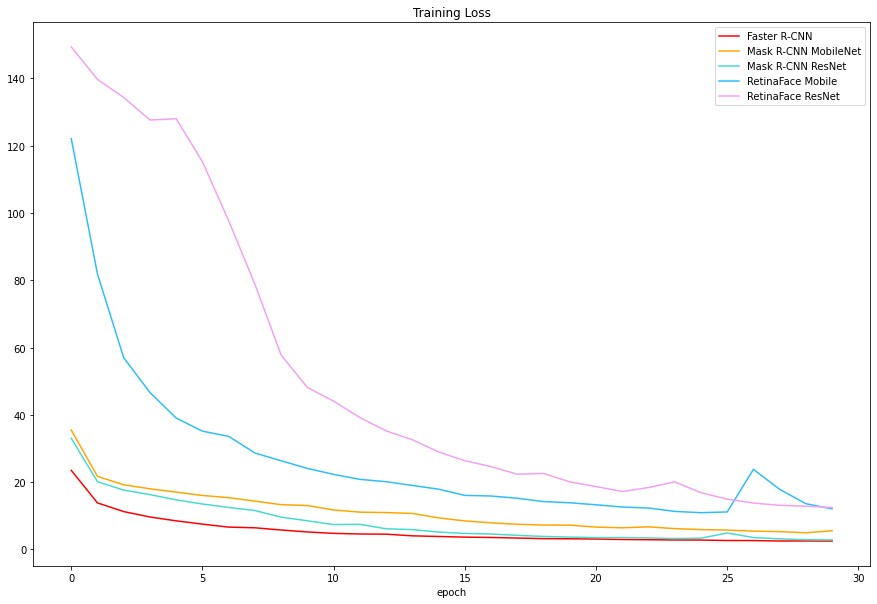

In [31]:
# plot training loss

plt.figure(figsize=(15,10))

for i in range(len(train_loss)):
    plt.plot(train_loss[i], c=color[i], label=names[i])
plt.title('Training Loss')      
plt.xlabel('epoch')
plt.legend()
plt.show()

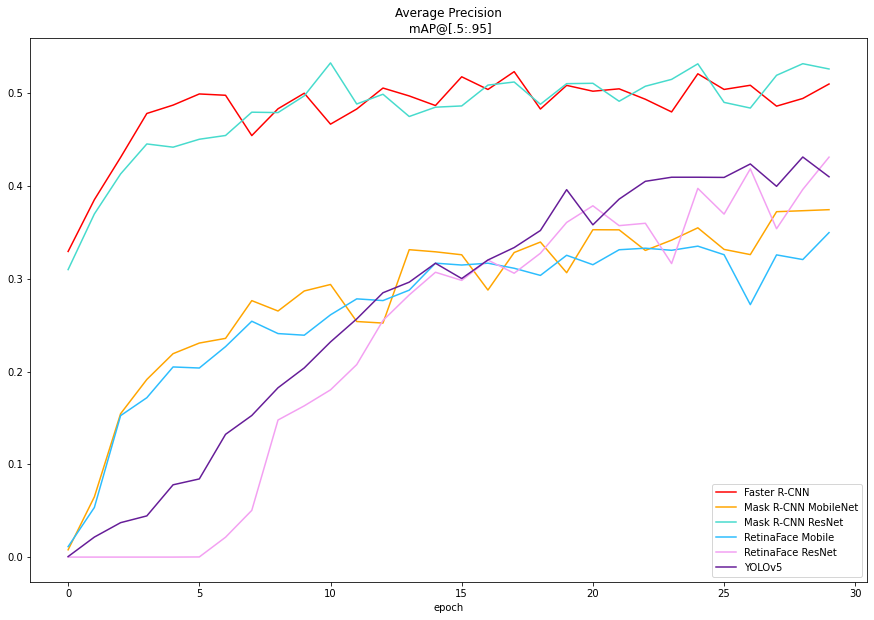

In [32]:
# plot mAP

plt.figure(figsize=(15,10))

for i in range(len(ap_filenames)):
      plt.plot(ap_filenames[i], c=color[i], label=names[i])
plt.title('Average Precision\n mAP@[.5:.95]')      
plt.xlabel('epoch')
plt.legend()
plt.show()

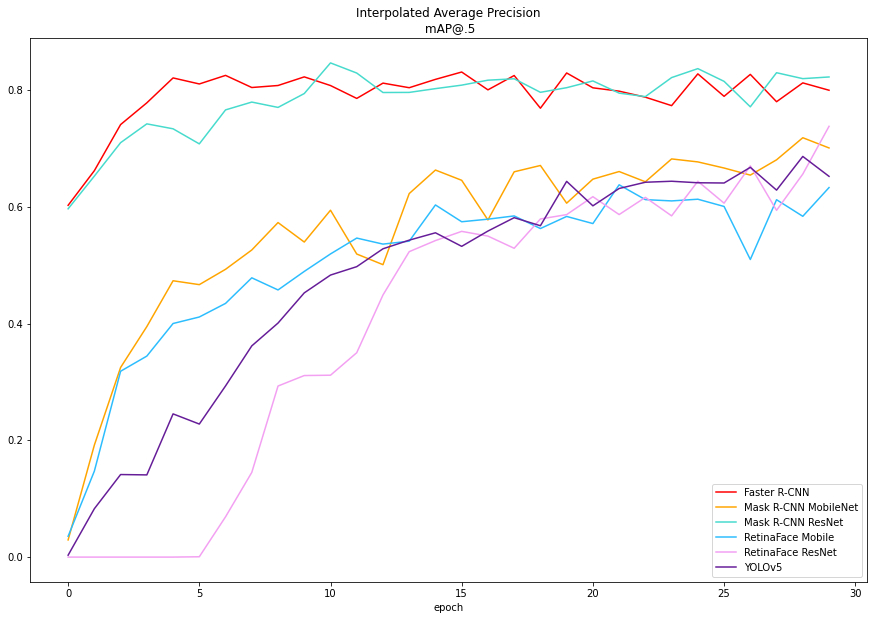

In [33]:
# plot interpolated mAP

plt.figure(figsize=(15,10))

for i in range(len(inter_filenames)):
      plt.plot(inter_filenames[i], c=color[i], label=names[i])
plt.title('Interpolated Average Precision\n mAP@.5')      
plt.xlabel('epoch')
plt.legend()
plt.show()

# Libraries Version and Hardware Type

In [34]:
print('PyTorch version: ', torch.__version__)

PyTorch version:  1.9.0+cu102


In [36]:
# matplotlib, cython, pycocotools, and beautifulsoup

!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.5
cftime==1.5.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==9.1.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3
dlib==1

In [37]:
!nvidia-smi

Mon Jun 21 05:02:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    37W / 300W |  14077MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Clearing RAM and GPU

In [ ]:
!ps -aux|grep python

root          47  0.1  0.4 195188 61116 ?        Sl   10:43   0:02 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --LargeFileManager.delete_to_trash=False --MappingKernelManager.root_dir="/content"
root          59  2.6 17.9 42314964 2393340 ?    Ssl  10:55   0:21 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-1f044c09-cb61-468c-9e07-9b7ffa1912fb.json
root          79  0.1  0.0      0     0 ?        Z    10:55   0:01 [python3] <defunct>
root         274  0.0  0.0      0     0 ?        Z    10:55   0:00 [python3] <defunct>
root         443  0.0  0.0  39204  6404 ?        S    11:08   0:00 /bin/bash -c ps -aux|grep python
root         445  0.0  0.0  38580  5548 ?        S    11:08   0:00 grep python


In [ ]:
!kill -9 79 274 443 445

/bin/bash: line 0: kill: (443) - No such process
/bin/bash: line 0: kill: (445) - No such process


In [ ]:
a=[]
while True:
    a.append('qwertyqwerty')